# The data structure
data_custom \\
> |- train.txt (one line per path to train image) \\
|- val.txt (one line per path to test image) \\
|- test.txt (one line per path to test image) \\
|- images \\
>>  |- train (folder, contains all images for train) \\
    |- val (folder, contains all images for val) \\
    |- test (folder, contains all images for test) \\
    
>|- labels \\
>>  | - train (folder, one .txt file per image for the YOLO annotation) \\
    | - val (folder, one .txt file per image for the YOLO annotation) \\
    | - test (folder, one .txt file per image for the YOLO annotation) \\

# Note:
If you haven't done so, you have to download yolov7 to your google drive first.
The link to that github is here: https://github.com/WongKinYiu/yolov7
It is highly recommended to store your yolov7 code in this directory (so it will work the same as mine): MyDrive/SHSU/Codes/roaddamagedetector/yolov7

Adopted from: https://towardsdatascience.com/convert-pascal-voc-xml-to-yolo-for-object-detection-f969811ccba5

In [1]:
import xml.etree.ElementTree as ET # parse xml anotation
import glob # grab files
import os # paths
import json # process json
import shutil # move file
from sklearn.model_selection import train_test_split # train test splitting
from tqdm import tqdm # progress
import random # random sample of images
from PIL import Image, ImageDraw # draw on images
from IPython.display import display # display images on jupyter notebook
import numpy as np
# reproducibility
np.random.seed(42)
random.seed(42)


In [ ]:
def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]
def yolo_to_xml_bbox(bbox, w, h):
    # x_center, y_center width heigth
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2
    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)
    return [xmin, ymin, xmax, ymax]

In [ ]:
cd /home/pham/Documents/SHSU/Researching/roaddamagedetector

/home/pham/Documents/SHSU/Researching/roaddamagedetector


In [ ]:
ls RDD2022/

China_Drone/      Czech/  Japan/   train.txt
China_MotorBike/  India/  Norway/  United_States/


In [ ]:
ls RDD2022/India/train/annotations/

xmls/


In [ ]:
input_dir = "RDD2022/"
classes = ["D00", "D10", "D20", "D40"]
train_countries = ["Czech", "India", "Japan", "Norway", "United_States", "China_MotorBike", "China_Drone"]
test_countries = ["Czech", "India", "Japan", "Norway", "United_States", "China_MotorBike"]

## Train files

In [ ]:
annotation_files = []
for c in train_countries:
  im_per_c = glob.glob(os.path.join(input_dir, c, "train/annotations/xmls/*.xml"))
  annotation_files += im_per_c

In [ ]:
print(len(annotation_files))

38385


# Convert all the annotations


In [ ]:
def convert_files(files, classes):
  converted_files = []
  for fil in tqdm(files):
      basename = os.path.basename(fil)
      filename = os.path.splitext(basename)[0]
      result = []
      # parse the content of the xml file
      tree = ET.parse(fil)
      root = tree.getroot()
      width = int(root.find("size").find("width").text)
      height = int(root.find("size").find("height").text)

      for obj in root.findall('object'):
          label = obj.find("name").text
          # check for new classes and append to list
          if label not in classes:
              continue
          index = classes.index(label)
          pil_bbox = [int(float(x.text)) for x in obj.find("bndbox")]
          yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
          # convert data to string
          bbox_string = " ".join([str(x) for x in yolo_bbox])
          result.append(f"{index} {bbox_string}")

      if result:
          # generate a YOLO format text file for each xml file
          converted_file = os.path.join(os.path.dirname(fil), f"{filename}.txt")
          with open(converted_file, "w", encoding="utf-8") as f:
              f.write("\n".join(result))
          converted_files.append(converted_file)
  return converted_files

In [ ]:
# convert
annotation_files = convert_files(annotation_files, classes)

In [ ]:
len(annotation_files)

23767

So there are files that don't have these damages (from 2020 dataset)

In [ ]:
# look at one of them
annotation_files[0]

'RDD2022/Czech/train/annotations/xmls/Czech_002477.txt'

In [ ]:
# Update stratified
annotation_stratified = [x.split('/')[1] for x in annotation_files]

In [ ]:
len(annotation_files)

23767

In [ ]:
file_train, file_test, c_train, c_test = train_test_split(annotation_files, annotation_stratified, test_size=0.025, stratify=annotation_stratified)

In [ ]:
file_train, file_val, c_train, c_val = train_test_split(file_train, c_train, stratify=c_train, test_size = 0.05/0.975)

In [ ]:
print(len(file_train))
print(len(file_val))
print(len(file_test))

21983
1189
595


In [ ]:
# convert the path of annotation file to the original file
def anno_to_img(f):
  return os.path.join("/".join(f.split("/")[:3]), "images", os.path.splitext(os.path.basename(f))[0] + ".jpg")

In [ ]:
anno_to_img(file_train[0])

'RDD2022/Japan/train/images/Japan_009620.jpg'

In [ ]:
ls 'RDD2022/Japan/train/images/Japan_008012.jpg'

RDD2022/Japan/train/images/Japan_008012.jpg


In [ ]:
# generate the classes file as reference
with open(os.path.join(input_dir, 'classes.txt'), 'w', encoding='utf8') as f:
    f.write(json.dumps(classes))

In [ ]:
# Create folder structure
os.makedirs(os.path.join(input_dir, "images", "train"), exist_ok=True)
os.makedirs(os.path.join(input_dir, "images", "val"), exist_ok=True)
os.makedirs(os.path.join(input_dir, "labels", "train"), exist_ok=True)
os.makedirs(os.path.join(input_dir, "labels", "val"), exist_ok=True)

# Move annotations accordingly

In [ ]:
# test is only for our internal validation
os.makedirs(os.path.join(input_dir, "images", "test"), exist_ok=True)
os.makedirs(os.path.join(input_dir, "labels", "test"), exist_ok=True)

In [ ]:
# Move all the train annotations
dest_dir = os.path.join(input_dir, "labels", "train")
for f in tqdm(file_train):
  shutil.move(f, dest_dir)

100%|██████████| 21983/21983 [00:00<00:00, 24854.90it/s]


In [ ]:
# Move all the val annotations
dest_dir = os.path.join(input_dir, "labels", "val")
for f in tqdm(file_val):
  shutil.move(f, dest_dir)

100%|██████████| 1189/1189 [00:00<00:00, 15995.91it/s]


In [ ]:
# Move all the test annotations
dest_dir = os.path.join(input_dir, "labels", "test")
for f in tqdm(file_test):
  shutil.move(f, dest_dir)

100%|██████████| 595/595 [00:00<00:00, 12613.65it/s]


# Move images accordingly


In [ ]:
# Move all the train images
dest_dir = os.path.join(input_dir, "images", "train")
for f in tqdm(file_train):
  shutil.move(anno_to_img(f), dest_dir)

100%|██████████| 21983/21983 [00:01<00:00, 20834.36it/s]


In [ ]:
# Move all the val images
dest_dir = os.path.join(input_dir, "images", "val")
for f in tqdm(file_val):
  shutil.move(anno_to_img(f), dest_dir)

100%|██████████| 1189/1189 [00:00<00:00, 14690.07it/s]


In [ ]:
# Move all the test images
dest_dir = os.path.join(input_dir, "images", "test")
for f in tqdm(file_test):
  shutil.move(anno_to_img(f), dest_dir)

100%|██████████| 595/595 [00:00<00:00, 10930.94it/s]


## Try visualizing some of them

In [ ]:
def draw_image(img, bboxes, labels):
    draw = ImageDraw.Draw(img)
    for i, bbox in enumerate(bboxes):
        draw.rectangle(bbox, outline="red", width=2)
        draw.text([bbox[0], bbox[1]-12], labels[i])
    display(img)

In [ ]:
def image_to_anno_file(image_filename):
  return os.path.join(input_dir, "labels/train/",  os.path.splitext(os.path.basename(image_filename))[0] + ".txt")  

In [ ]:
def anno_to_image_file(anno_filename):
  return os.path.join(input_dir, "images/train/",  os.path.splitext(os.path.basename(anno_filename))[0] + ".jpg")    

In [ ]:
# get all the train files up again
file_train = glob.glob(os.path.join(input_dir, "labels/train", "*.txt"))
print(len(file_train))

21983


In [ ]:
anno_to_image_file(file_train[0])

'RDD2022/images/train/Japan_002263.jpg'

In [ ]:
def draw_random_img():
  anno_files = file_train
  image_filename = anno_to_image_file(random.sample(anno_files, 1)[0])
  label_filename = image_to_anno_file(image_filename)
  bboxes = []
  labels = []
  img = Image.open(image_filename)
  if os.path.exists(label_filename):
    with open(label_filename, 'r', encoding='utf8') as f:
        for line in f:
            data = line.strip().split(' ')
            bbox = [float(x) for x in data[1:]]
            coords = yolo_to_xml_bbox(bbox, img.width, img.height)
            labels.append(classes[int(data[0])])
            bboxes.append(coords)
  draw_image(img, bboxes, labels)
  print(os.path.basename(image_filename))

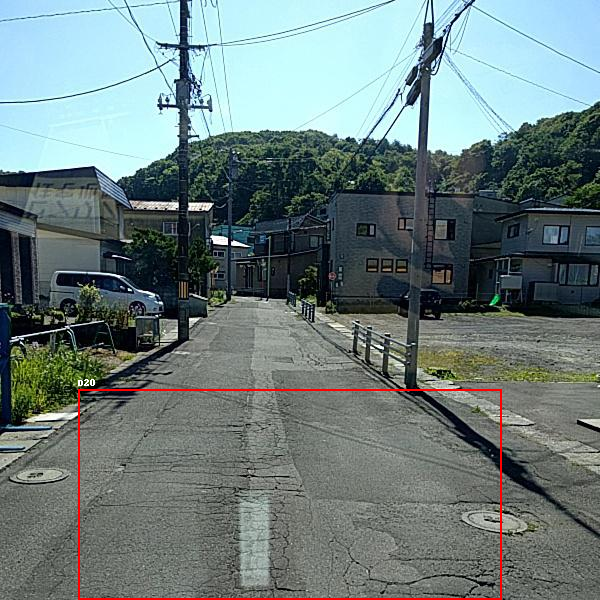

Japan_002390.jpg


In [ ]:
draw_random_img()

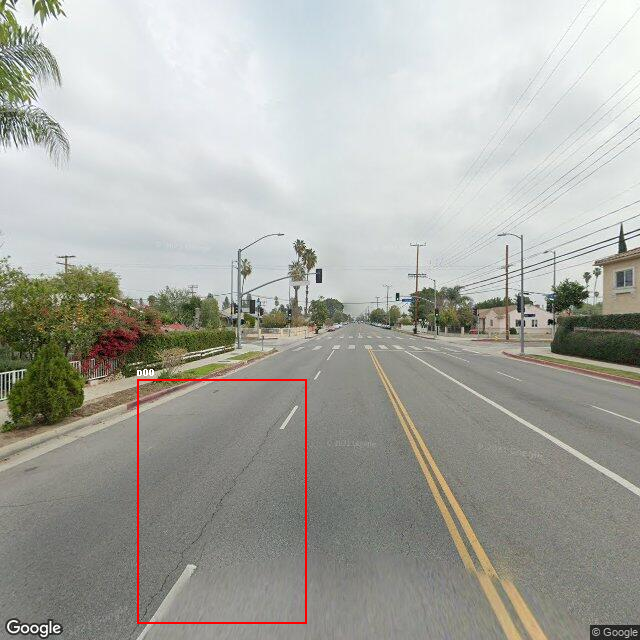

United_States_001528.jpg


In [ ]:
draw_random_img()

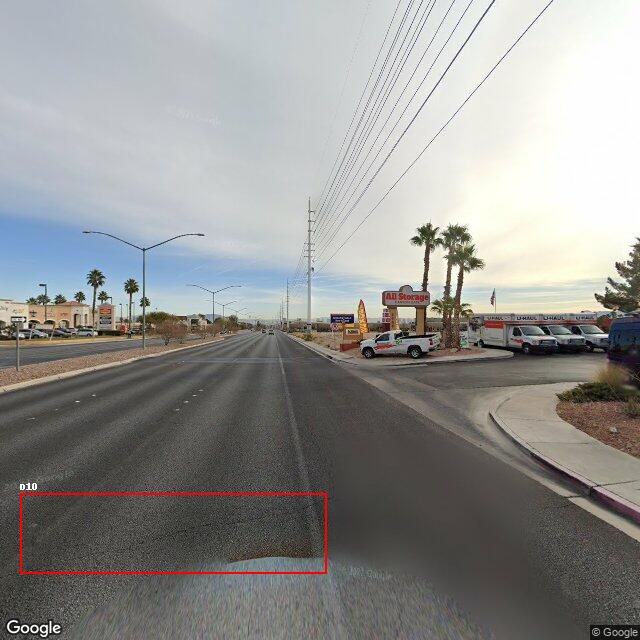

United_States_001433.jpg


In [ ]:
draw_random_img()

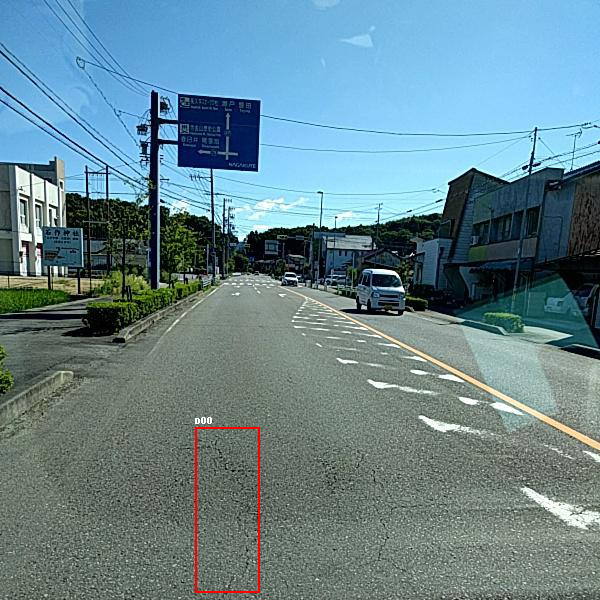

Japan_000365.jpg


In [ ]:
draw_random_img()

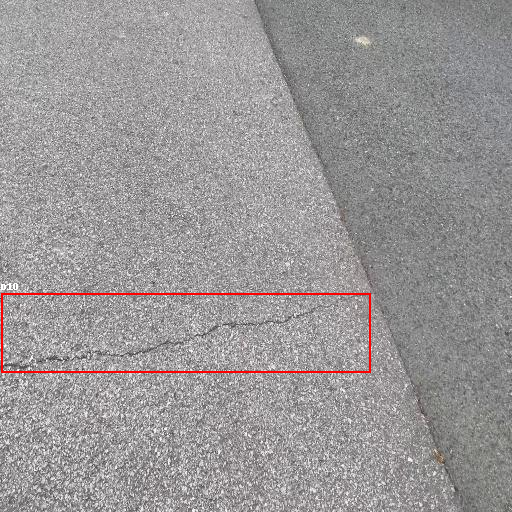

China_MotorBike_001143.jpg


In [ ]:
draw_random_img()

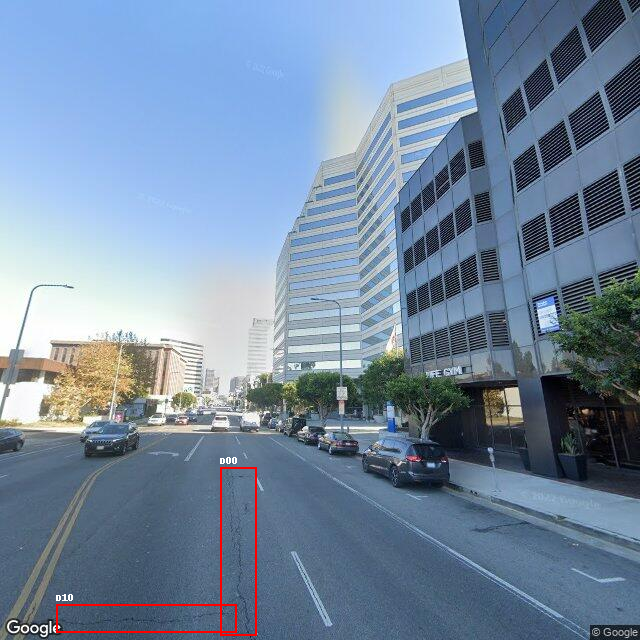

United_States_004134.jpg


In [ ]:
draw_random_img()

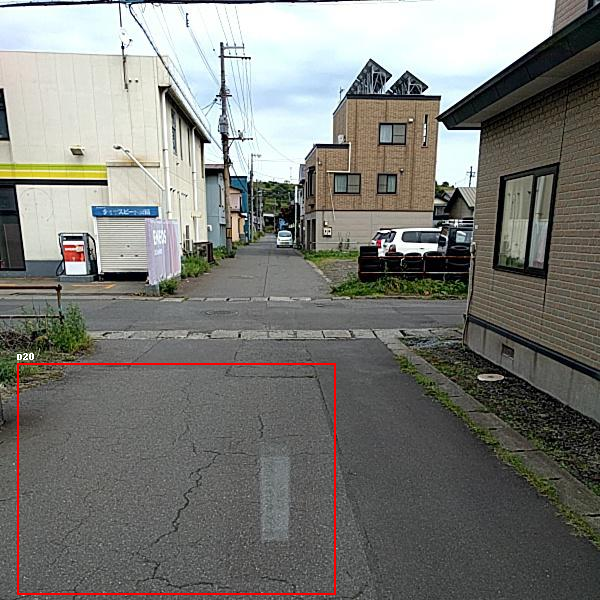

Japan_007920.jpg


In [ ]:
draw_random_img()

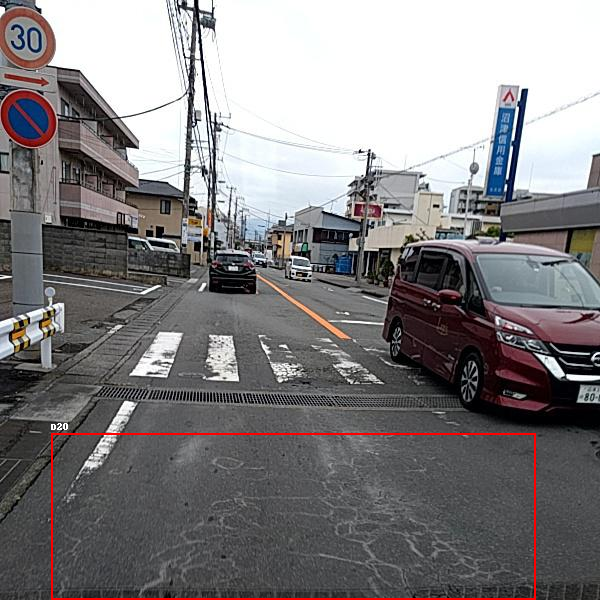

Japan_009020.jpg


In [ ]:
draw_random_img()

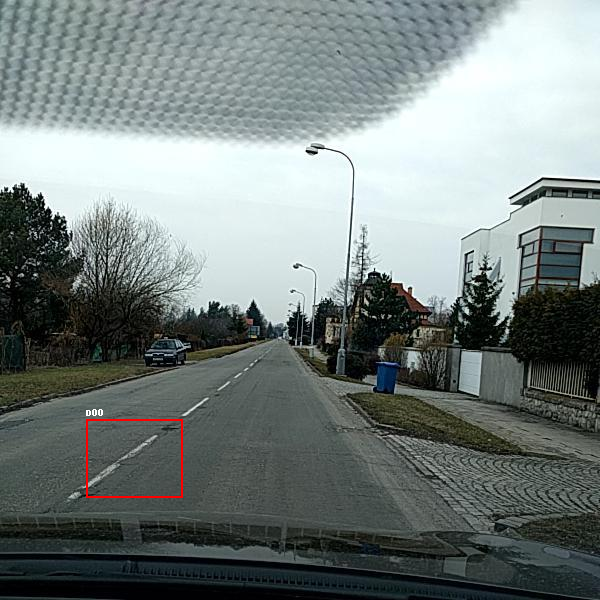

Czech_001908.jpg


In [ ]:
draw_random_img()